In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
import logging
logging.basicConfig(level=logging.ERROR)

In [5]:
!pip install transformers==3

     |████████████████████████████████| 757kB 4.4MB/s 
     |████████████████████████████████| 1.2MB 13.4MB/s 
     |████████████████████████████████| 901kB 24.4MB/s 
     |████████████████████████████████| 3.0MB 31.7MB/s 


#Data

In [6]:
import pandas as pd
# import pytreebank

%cd drive/My Drive/Colab Notebooks/experiments/data

# Load the dataset into a pandas dataframe.
df = pd.read_csv("Datasets/es_lcc_new.csv")
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.head()

/content/drive/My Drive/Colab Notebooks/experiments/data
Number of training sentences: 20,694



,sentence,text_context_next,text_context_prev,polarity,intensity,source_concept,target_concept,label
0,También cursan en su contra 22 procesos más po...,Esos 26 mil millones de pesos (que pagaron baj...,"Sin embargo, hay otro proceso que les podría s...",NEGATIVE,3.0,BACKWARD_MOVEMENT,TAXATION,0
1,También cursan en su contra 22 procesos más po...,Esos 26 mil millones de pesos (que pagaron baj...,"Sin embargo, hay otro proceso que les podría s...",POSITIVE,3.0,BACKWARD_MOVEMENT,TAXATION,0
2,También cursan en su contra 22 procesos más po...,Esos 26 mil millones de pesos (que pagaron baj...,"Sin embargo, hay otro proceso que les podría s...",NEGATIVE,1.0,BACKWARD_MOVEMENT,TAXATION,0
3,También cursan en su contra 22 procesos más po...,Esos 26 mil millones de pesos (que pagaron baj...,"Sin embargo, hay otro proceso que les podría s...",POSITIVE,1.0,BACKWARD_MOVEMENT,TAXATION,0
4,También cursan en su contra 22 procesos más po...,Esos 26 mil millones de pesos (que pagaron baj...,"Sin embargo, hay otro proceso que les podría s...",NEGATIVE,3.0,BACKWARD_MOVEMENT,TAXATION,1


In [7]:
#if label was not numeric
#from sklearn.preprocessing import LabelEncoder

#encoder = LabelEncoder()
#df.label = encoder.fit_transform(df.label)

In [8]:
# Class count
count_class_0, count_class_1 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

Random under-sampling:
1    9270
0    9270
Name: label, dtype: int64


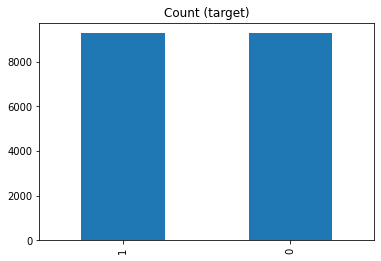

In [9]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [10]:
df = df_test_under

In [11]:
df.shape

(18540, 8)

In [12]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values.astype(str)
labels = df.label.values
labels

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
# Split to train, val and test
from sklearn.model_selection import train_test_split as tts
train, test_df = tts(df[['sentence', 'polarity', 'intensity', 'source_concept', 'target_concept', "label"]], random_state=42, test_size=0.1)
train, val = tts(train, random_state=42, test_size=test_df.shape[0])

#Tokenizer

In [14]:
!pip install sentencepiece

In [15]:
from transformers import XLMRobertaTokenizer

# Load the BERT tokenizer.
print('Loading XLMRobertaTokenizer ...')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

Loading XLMRobertaTokenizer ...


In [16]:
# Print the original sentence.
print('Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Mucho gusto  en dictar cuantas disposiciones legales sean convenientes para favorecer los intereses locales de Oaxaca; pero no puedo ni debo, como usted comprenderá, adoptar ninguna medida que perjudique a los demás estados, pues todos tienen igual  a la protección del gobierno, cuyos actos deben estar basados en la más estricta imparcialidad.
Tokenized:  ['▁mucho', '▁gusto', '▁en', '▁dicta', 'r', '▁cu', 'anta', 's', '▁disposi', 'ciones', '▁legale', 's', '▁sean', '▁conveniente', 's', '▁para', '▁favorece', 'r', '▁los', '▁intereses', '▁locales', '▁de', '▁o', 'ax', 'aca', ';', '▁pero', '▁no', '▁puedo', '▁ni', '▁de', 'bo', ',', '▁como', '▁usted', '▁comprender', 'á', ',', '▁adoptar', '▁ninguna', '▁medida', '▁que', '▁per', 'ju', 'dique', '▁a', '▁los', '▁demás', '▁estados', ',', '▁pues', '▁todos', '▁tienen', '▁igual', '▁a', '▁la', '▁protección', '▁del', '▁gobierno', ',', '▁cuyo', 's', '▁actos', '▁deben', '▁estar', '▁basa', 'dos', '▁en', '▁la', '▁más', '▁e', 'strict', 'a', '▁impar',

#Tokenize Dataset

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('labels:', labels)

Original:  Mucho gusto  en dictar cuantas disposiciones legales sean convenientes para favorecer los intereses locales de Oaxaca; pero no puedo ni debo, como usted comprenderá, adoptar ninguna medida que perjudique a los demás estados, pues todos tienen igual  a la protección del gobierno, cuyos actos deben estar basados en la más estricta imparcialidad.
Token IDs: tensor([     0,  10764,  13372,     22,  28214,     42,    314,   4119,      7,
         91471,   3825,  82546,      7,  52451, 142247,      7,    121, 113494,
            42,    388,  72593,  83221,      8,     36,  14263,   8355,     74,
          1788,    110,  62040,    300,      8,    837,      4,    533,  52364,
         93750,    709,      4, 189072,  80230,  27442,     41,    117,    461,
        146253,     10,    388,  62552, 114602,      4,  33007,   2194,  17432,
         15353,     10,     21,  54756,    146,  41783,      4, 110787,      7,
         87785,  38098,   5747,  16352,   1140,     22,     21,   1005, 

#Train and validation split

In [18]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,686 training samples
1,854 validation samples


In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


#Train the model - XLMRobertaForSequenceClassification

In [20]:
from transformers import XLMRobertaForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification - pretrained BERT model with a single linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [21]:
params = list(model.named_parameters())

print('The XLMRoberta model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLMRoberta model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias     

#Optimizer and Learning Rate Scheduler

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) - "W" stands for weight decay fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#Train our model

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    522.    Elapsed: 0:00:17.
  Batch    80  of    522.    Elapsed: 0:00:33.
  Batch   120  of    522.    Elapsed: 0:00:50.
  Batch   160  of    522.    Elapsed: 0:01:07.
  Batch   200  of    522.    Elapsed: 0:01:23.
  Batch   240  of    522.    Elapsed: 0:01:40.
  Batch   280  of    522.    Elapsed: 0:01:57.
  Batch   320  of    522.    Elapsed: 0:02:13.
  Batch   360  of    522.    Elapsed: 0:02:30.
  Batch   400  of    522.    Elapsed: 0:02:47.
  Batch   440  of    522.    Elapsed: 0:03:03.
  Batch   480  of    522.    Elapsed: 0:03:20.
  Batch   520  of    522.    Elapsed: 0:03:37.

  Average training loss: 0.57
  Training epcoh took: 0:03:37

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.46
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    522.    Elapsed: 0:00:17.
  Batch    80  of    522.    Elapsed: 0:00:33.
  Batch   120  of    522.    Elapsed: 0:00:50.
  Batch  

In [27]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.57,0.46,0.79,0:03:37,0:00:07
2,0.40,0.39,0.83,0:03:37,0:00:07
3,0.31,0.39,0.84,0:03:37,0:00:07
4,0.25,0.40,0.85,0:03:37,0:00:07


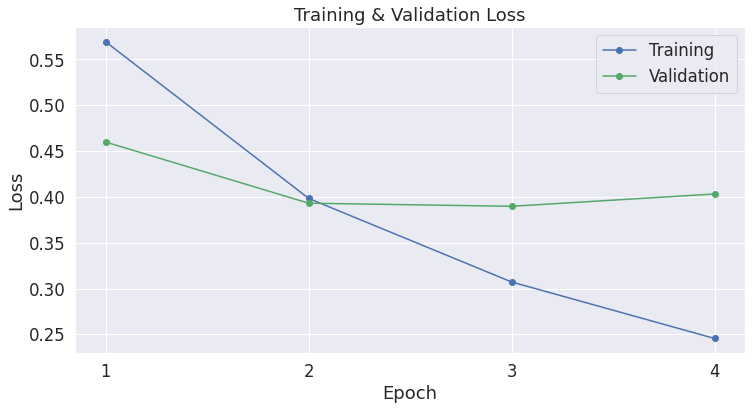

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Performance on test set

In [29]:
import pandas as pd

# # Load the dataset into a pandas dataframe.
#test_df = pd.read_csv("Datasets/es_lcc_new.csv")

# # Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
sentences = test_df.sentence.values.astype(str)
labels = test_df.label.values

# # Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# # For every sentence...
for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
     encoded_dict = tokenizer.encode_plus(
                         sent,                      # Sentence to encode.
                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                         max_length = 64,           # Pad & truncate all sentences.
                         pad_to_max_length = True,
                         return_attention_mask = True,   # Construct attn. masks.
                         return_tensors = 'pt',     # Return pytorch tensors.
                    )
    
#     # Add the encoded sentence to the list.    
     input_ids.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Set the batch size.  
batch_size = 32  

# # Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 18,540



## Save and load fine-tuned model

In [30]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'es_lcc_xlmroberta/xlm-roberta_model_save'
# output_dir = './content/xlm-roberta_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to es_lcc_xlmroberta/xlm-roberta_model_save


('es_lcc_xlmroberta/xlm-roberta_model_save/sentencepiece.bpe.model',
 'es_lcc_xlmroberta/xlm-roberta_model_save/special_tokens_map.json',
 'es_lcc_xlmroberta/xlm-roberta_model_save/added_tokens.json')

In [31]:
!pip install transformers

from transformers import XLMRobertaForSequenceClassification

output_dir = 'mohx_xlmroberta/xlm-roberta_model_save'

print(output_dir)

mohx_xlmroberta/xlm-roberta_model_save


In [32]:
from transformers import XLMRobertaTokenizer
import torch
# Load the BERT tokenizer.
print('Loading XLMRobertaTokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(output_dir)
model_loaded = XLMRobertaForSequenceClassification.from_pretrained(output_dir)

Loading XLMRobertaTokenizer...


#Evaluation on test set

In [33]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [34]:
my_submission = pd.DataFrame()
my_submission['sentence'] = test_df['sentence']
my_submission['correct_label'] = test_df['label']

In [35]:
final_preds = []
for p in predictions:
    for i in p:
        final_preds.append(np.argmax(i))

In [36]:
my_submission['label'] = final_preds

In [37]:
my_submission['label'] = my_submission['label'].map({0:0, 1:1})

In [38]:
my_submission.head()

,sentence,correct_label,label
964,"Y otra más, es que aunque al inicio de año hab...",1,1
11270,Todavía lo recuerdo y un voto: 'Nunca tendré...,0,0
14145,Cataluña es una oligarquía de las grandes fami...,0,0
9626,(Texcoco Mass Media).- Fue en Texcoco converti...,0,0
3530,- ¡La de nuestra radica en la fuerza de la c...,0,0


In [39]:
my_submission.shape

(1854, 3)

In [40]:
test_df.label.value_counts()

1    939
0    915
Name: label, dtype: int64

In [41]:
final = my_submission[(my_submission['correct_label'] == my_submission['label'])]

In [42]:
final.shape

(1704, 3)

In [43]:
final_met = my_submission[(my_submission['correct_label'] == 1) & (my_submission['label'] ==1)]

In [44]:
final_met.shape

(846, 3)

In [45]:
final_lit = my_submission[(my_submission['correct_label'] == 0) & (my_submission['label'] ==0)]

In [46]:
final_lit.shape

(858, 3)

In [47]:
my_submission.to_csv('es_lcc_sub.csv', index=False)